In [1]:
import os
import time
import numpy as np
import pickle
import gc
from matplotlib import pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.utils as vutils

In [2]:
CUDA = 'cuda:0'
DEVICE = torch.device(CUDA if torch.cuda.is_available() else "cpu")
data_path = '/home/deepak/CS_MRI_codes_simulation/MRI_MCCAI_data/training_gt_split'
model_save_path = '/home/deepak/CS_MRI_codes_simulation/MRI_MCCAI_data/'

In [3]:
#Architecture build
#subclassing 

class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.dense0 = nn.Linear(1024, 4*4*256)
        self.bn0 = nn.BatchNorm1d(4*4*256)

        self.tconv1 = nn.ConvTranspose2d(256, 192, 4, 2, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(192)

        self.tconv2 = nn.ConvTranspose2d(192, 128, 4, 2, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(128)

        self.tconv3 = nn.ConvTranspose2d(128, 64 , 4, 2, padding=1, bias=False)
        self.bn3 = nn.BatchNorm2d(64)
        
        self.tconv4 = nn.ConvTranspose2d(64, 32, 4, 2, padding=1, bias=False)
        self.bn4 = nn.BatchNorm2d(32)
        
        self.tconv5 = nn.ConvTranspose2d(32, 16 , 4, 2, padding=1, bias=False)
        self.bn5 = nn.BatchNorm2d(16)
        
        self.tconv6 = nn.ConvTranspose2d(16, 1, 4, 2, padding=1, bias=False)
        
        

    def forward(self, x):
        x = F.relu(self.dense0(x))
        x = torch.reshape(x, (-1,256,4,4))
        x = F.relu(self.bn1(self.tconv1(x)))
        x = F.relu(self.bn2(self.tconv2(x)))
        x = F.relu(self.bn3(self.tconv3(x)))
        x = F.relu(self.bn4(self.tconv4(x)))
        x = F.relu(self.bn5(self.tconv5(x)))
        img = torch.tanh(self.tconv6(x))

        return img

class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Conv2d(1, 16, 5, 2, 2, bias=False)
        self.bn1 = nn.BatchNorm2d(16)

        self.conv2 = nn.Conv2d(16, 32, 5, 2, 2, bias=False)
        self.bn2 = nn.BatchNorm2d(32)

        self.conv3 = nn.Conv2d(32, 64, 5, 2, 2, bias=False)
        self.bn3 = nn.BatchNorm2d(64)

        self.conv4 = nn.Conv2d(64, 128, 5, 2, 2, bias=False)
        self.bn4 = nn.BatchNorm2d(128)

        self.conv5 = nn.Conv2d(128, 192, 5, 2, 2, bias=False)
        self.bn5 = nn.BatchNorm2d(192)

        self.conv6_flatten = nn.Sequential(nn.Conv2d(192, 256, 5, 2, 2, bias=False),
                                          nn.BatchNorm2d(256),
                                          nn.LeakyReLU(True),
                                          nn.Flatten()
                                          )
        
        self.dense7 = nn.Linear(4096,1024)
        self.bn7 = nn.BatchNorm1d(1024)
        

        
    def forward(self, x):
        x = F.leaky_relu(self.bn1(self.conv1(x)), 0.1, inplace=True)
        x = F.leaky_relu(self.bn2(self.conv2(x)), 0.1, inplace=True)
        x = F.leaky_relu(self.bn3(self.conv3(x)), 0.1, inplace=True)
        x = F.leaky_relu(self.bn4(self.conv4(x)), 0.1, inplace=True)
        x = F.leaky_relu(self.bn5(self.conv5(x)), 0.1, inplace=True)
        x = self.conv6_flatten(x)
        x = F.leaky_relu(self.bn7(self.dense7(x)), 0.1, inplace=True)
        return x

class DHead(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.dense1 = nn.Linear(1024,100) 
        self.dense2 = nn.Linear(100,1)
        
    def forward(self, x):
        x = torch.relu(self.dense1(x))
        output = torch.sigmoid(self.dense2(x))
        return output

class QHead(nn.Module):
    def __init__(self,CODE_DIM):
        super().__init__()
        
        self.dense1 = nn.Linear(1024, 500)
        self.bn1 = nn.BatchNorm1d(500)
        self.dense2 = nn.Linear(500, CODE_DIM)

    def forward(self, x):
        x = F.leaky_relu(self.bn1(self.dense1(x)), 0.1, inplace=True)

        code_cap = torch.sigmoid(self.dense2(x)) #activation changed to sigmoid(disc_codes)

        return code_cap
    
class Projector(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.fc1 = nn.Linear(65536, 4096)
        self.bn1 = nn.BatchNorm1d(4096)
        self.fc2 = nn.Linear(4096,2048)
        self.bn2 = nn.BatchNorm1d(2048)
        self.fc3 = nn.Linear(2048,1024)

    def forward(self, x):
        x = F.relu(self.bn1(self.fc1(x)))
        x = F.relu(self.bn2(self.fc2(x)))
        latent_est = self.fc3(x)
        
        return latent_est


In [4]:
#functions for loading the data as a randomized batch
def load_data(file_name):
    with open(file_name,'rb') as f:
        data = pickle.load(f)
    f.close()
    gc.collect()
    return data

def batch_wise_split(n_files, batch_size):
    X = np.arange(n_files)
    random_file_choice = np.random.choice(X, 1)
    file_name = 'train_gt_%04d.pickle'% (random_file_choice+1)
    #print(random_file_choice+1)
    data_loaded = load_data(os.path.join(data_path, file_name))
    #from data loaded select any 32 samples(slices)
    slice_sel_array = np.arange(len(data_loaded))
    slice_sel = np.random.choice(slice_sel_array, batch_size, replace = False)
    #print(slice_sel)
    X_train = []
    for i in slice_sel:
        X_train.append(data_loaded[i])
    return X_train

In [5]:
# construction of the latent variable (Returns a batch of latent variable) 
def make_cont_codes(n_code_vec, n_samples):
    cont_codes = np.random.uniform(-1,1,size = (n_samples, n_code_vec))
    return cont_codes
def make_disc_codes(n_disc_code_vec, n_samples):
    cat = np.random.randint(0, n_disc_code_vec, n_samples)
    cat_codes = np.zeros((n_samples, n_disc_code_vec))
    for i in range(n_samples):
        cat_codes[i,cat[i]] = np.int(1)  
    return cat_codes
def generate_latent_points(latent_dim, n_disc_code_vec, n_samples):
    z_latent = np.random.randn(latent_dim*n_samples)
    z_latent = z_latent.reshape(n_samples, latent_dim)
#     cont_codes = make_cont_codes(n_code_vec, n_samples)
    disc_codes = make_disc_codes(n_disc_code_vec, n_samples)
    z_input = np.hstack((z_latent,disc_codes))
    return [torch.Tensor(z_input), torch.tensor(disc_codes, dtype = torch.long)]
    

In [6]:
# def smooth_fake_labels(y):
#     y = y + 0.01 #(np.random.random(y.shape)*0.3)
#     return y
# def smooth_real_labels(y):
#     y = y - 0.1 #(np.random.random(y.shape)*0.3)
#     return y

In [7]:
def noisy_labels(y, p_flip):
    n_select = int(p_flip * y.shape[0])
    flip_index = np.random.choice([i for i in range(y.shape[0])],size = n_select)
    y[flip_index] = 1 - y[flip_index]
    return y

In [8]:
def add_noise(X):
    noise = np.random.normal(0, 0.1, X[0,0,:,:].shape)
    X = X + noise
    return X 

In [9]:
def generate_real_samples(n_files, n_samples): 
    # loads and lables n_samples of ground truth data in in a random order 
    X = np.reshape(np.array(batch_wise_split(n_files, n_samples)),(n_samples,-1,256,256))
    y = np.ones((n_samples, 1))
    y = noisy_labels(y, 3/32)
    #y = smooth_real_labels(y)
    return torch.Tensor(X), torch.Tensor(y)

def generate_fake_samples(generator, z_input, n_samples):
    images = generator(z_input)                  
    y = np.zeros((n_samples, 1))
    y = noisy_labels(y, 1/32)
    #y = smooth_fake_labels(y)
    return images, torch.Tensor(y)

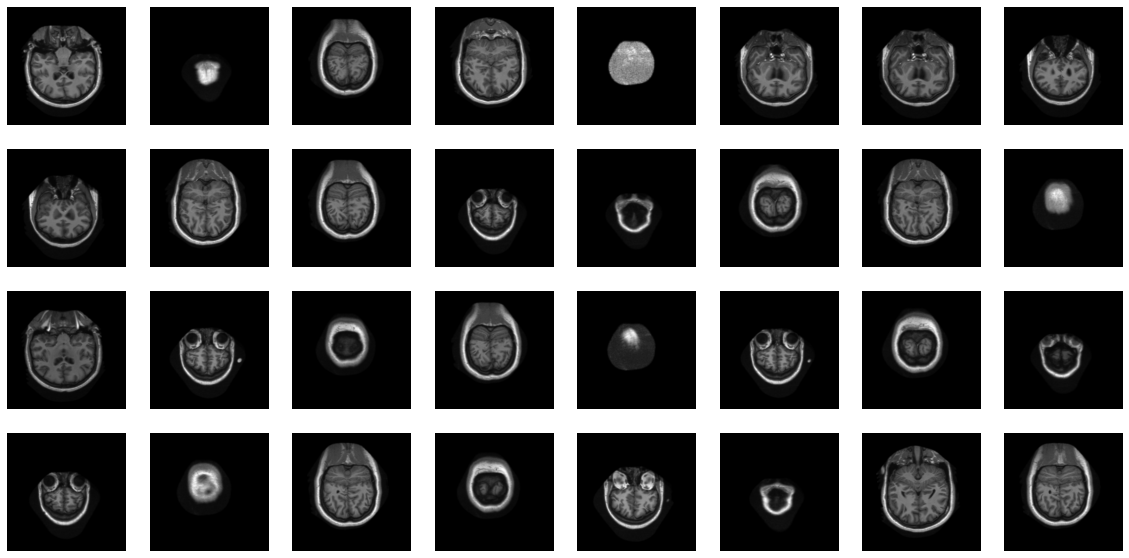

In [10]:
X, _ = generate_real_samples(100, 32)
fig = plt.figure(figsize=(20,10))
for i in range(32):
    plt.subplot(4,8,i+1)
    plt.axis('off')
    plt.imshow(X[i][0,:,:], cmap = 'gray')
plt.show()

In [11]:
# noisy = add_noise(X)
# noisy.shape

In [12]:
# for i in range(1):
#     plt.subplot(1,2,1)
#     plt.axis('off')
#     plt.imshow(noisy[5,0,:,:], cmap = 'gray')
#     plt.subplot(1,2,2)
#     plt.axis('off')
#     plt.imshow(X[5,0,:,:], cmap = 'gray')
# plt.show()

In [11]:
#weights init function
def weights_init(m):
    """
    Initialise weights of the model.
    """
    if(type(m) == nn.ConvTranspose2d or type(m) == nn.Conv2d or type(m) == nn.Linear):
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif(type(m) == nn.BatchNorm2d or type(m) == nn.BatchNorm1d):
        nn.init.normal_(m.weight.data, 1.0, 0.05)
        nn.init.constant_(m.bias.data, 0)
        
def weights_init_codes(m):
    if(type(m) == nn.Linear):
        nn.init.constant_(m.weight.data, 0)


In [12]:
# Initialise the network.
g_model = Generator().to(DEVICE)
g_model.apply(weights_init)
#print(g_model)

d_model = Discriminator().to(DEVICE)
d_model.apply(weights_init)
#print(d_model)

netD = DHead().to(DEVICE)
netD.apply(weights_init)
#print(netD)

netQ = QHead(265).to(DEVICE)
netQ.apply(weights_init)
#print(netQ)

proj_model = Projector().to(DEVICE)
proj_model.apply(weights_init)
#print(proj_model)

Projector(
  (fc1): Linear(in_features=65536, out_features=4096, bias=True)
  (bn1): BatchNorm1d(4096, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=4096, out_features=2048, bias=True)
  (bn2): BatchNorm1d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=2048, out_features=1024, bias=True)
)

In [13]:
from torchsummary import summary
summary(g_model,(1024,))
summary(d_model,(1,256,256))
summary(netD,(1024,))
summary(netQ,(1024,))
summary(proj_model,(65536,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                 [-1, 4096]       4,198,400
   ConvTranspose2d-2            [-1, 192, 8, 8]         786,432
       BatchNorm2d-3            [-1, 192, 8, 8]             384
   ConvTranspose2d-4          [-1, 128, 16, 16]         393,216
       BatchNorm2d-5          [-1, 128, 16, 16]             256
   ConvTranspose2d-6           [-1, 64, 32, 32]         131,072
       BatchNorm2d-7           [-1, 64, 32, 32]             128
   ConvTranspose2d-8           [-1, 32, 64, 64]          32,768
       BatchNorm2d-9           [-1, 32, 64, 64]              64
  ConvTranspose2d-10         [-1, 16, 128, 128]           8,192
      BatchNorm2d-11         [-1, 16, 128, 128]              32
  ConvTranspose2d-12          [-1, 1, 256, 256]             256
Total params: 5,551,200
Trainable params: 5,551,200
Non-trainable params: 0
---------------------------

In [14]:
import torch.optim as optim

In [15]:
# loss functions and optimizer instantiation

D_loss = nn.BCELoss()
Q_loss = nn.CrossEntropyLoss()

D_optim = optim.Adam([{'params': d_model.parameters()}, {'params': netD.parameters()}], lr=0.002, betas=(0.5,0.999))
G_optim = optim.Adam([{'params':g_model.parameters()}, {'params':netQ.parameters()}], lr=0.002, betas=(0.5,0.999))

In [16]:
#Training the network

In [17]:
# List variables to store results pf training.
img_list = []
G_losses = []
D_losses = []
Q_losses = []

In [18]:
num_epochs = 70
save_epoch = 69
batch_size = 32
n_batches = 30
n_files = 100
latent_dim = 1024-265
n_code_vec =265

In [19]:
checkpoint = torch.load(os.path.join(model_save_path,'checkpoint_model_4_5_d0_0001_g0_0001.pickle'))
g_model.load_state_dict(checkpoint['netG'])
d_model.load_state_dict(checkpoint['discriminator'])
netD.load_state_dict(checkpoint['netD'])
netQ.load_state_dict(checkpoint['netQ'])                 
D_optim.load_state_dict(checkpoint['D_optim'])
G_optim.load_state_dict(checkpoint['G_optim'])
D_losses = checkpoint['D_losses'] 
G_losses = checkpoint['G_losses']
Q_losses = checkpoint['Q_losses']
# g_model.eval()
# d_model.eval()
# netD.eval()
# netQ.eval()

In [ ]:
print(D_optim)
print(G_optim)

In [ ]:
print("-"*25)
print("Starting Training Loop...\n")
print('Epochs %d: Batch Size %d:' % (num_epochs, batch_size))
print("-"*25)

In [ ]:
start_time = time.time()
iters = 0

for epoch in range(num_epochs):
    epoch_start_time = time.time()

    for i in range(n_batches):
        # Get half batch size
        half_batch_size = int(batch_size/2)
        # Transfer data tensor to GPU/CPU (DEVICE)
        real_data, real_labels = generate_real_samples(n_files, half_batch_size)
        real_data = real_data.to(DEVICE)
        real_labels = real_labels.view(-1).to(DEVICE)

        # Updating discriminator and DHead
        D_optim.zero_grad()
        output1 = d_model(real_data)
        probs_real = netD(output1).view(-1)
        loss_real = D_loss(probs_real, real_labels)
        
        # Calculate gradients.
        loss_real.backward()

        # Fake data
        noise, disc_codes = generate_latent_points(latent_dim, n_code_vec, half_batch_size)
        noise = noise.to(DEVICE)
        disc_codes = disc_codes.to(DEVICE)
        fake_data, fake_labels = generate_fake_samples(g_model, noise ,half_batch_size)
        fake_data = fake_data.to(DEVICE)
        fake_labels = fake_labels.view(-1).to(DEVICE)
        output2 = d_model(fake_data.detach())
        probs_fake = netD(output2).view(-1)
        loss_fake = D_loss(probs_fake, fake_labels)
        
        # Calculate gradients.
        loss_fake.backward()

        # Net Loss for the discriminator
        total_D_loss = loss_real + loss_fake
        # Update parameters
        D_optim.step()

        
        
        # Updating Generator and QHead
        G_optim.zero_grad()
        
        noise_g, disc_codes_g = generate_latent_points(latent_dim, n_code_vec, batch_size)
        noise_g = noise_g.to(DEVICE)
        disc_codes_g = disc_codes_g.to(DEVICE)
        fake_data_g, _ = generate_fake_samples(g_model, noise_g, batch_size)
        fake_data_g = fake_data_g.to(DEVICE)
        invert_labels = torch.ones(batch_size,).to(DEVICE)
        # Fake data treated as real.
        output = d_model(fake_data_g)
        probs_fake = netD(output).view(-1)
        gen_loss = D_loss(probs_fake, invert_labels)

        q_output = netQ(output)
        target = (disc_codes_g == 1).nonzero(as_tuple=True)[1]
        q_loss = Q_loss(q_output, target)
        
        # Net loss for generator.
        G_loss = gen_loss + q_loss
        # Calculate gradients.
        G_loss.backward()
        # Update parameters.
        G_optim.step()

        # Check progress of training.
        if i != 0 and i%15 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tLoss_Q: %.4f'% (epoch+1, num_epochs, i, n_batches, total_D_loss.item(), gen_loss.item(), q_loss.item()))

        # Save the losses for plotting.
        G_losses.append(gen_loss.item())
        Q_losses.append(q_loss.item())
        D_losses.append(total_D_loss.item())

        iters += 1

    epoch_time = time.time() - epoch_start_time
    print("Time taken for Epoch %d: %.2fs" %(epoch + 1, epoch_time))
    
#     if (epoch+1) % 50 == 0:
#         torch.save({
#             'netG' : g_model.state_dict(),
#             'discriminator' : d_model.state_dict(),
#             'netD' : netD.state_dict(),
#             'netQ' : netQ.state_dict(),
#             'D_optim' : D_optim.state_dict(),
#             'G_optim' : G_optim.state_dict(),
#             }, os.path.join(model_save_path,'checkpoint_model_alt_epoch_%d.pickle'%(epoch+1))) 

    
#     # Generate image after each epoch to check performance of the generator. Used for creating animated gif later.
#     with torch.no_grad():
#         gen_data = g_model(noise).detach().cpu()
#     img_list.append(vutils.make_grid(gen_data, nrow=8, padding=0, normalize=False))

#     # Generate image to check performance of generator.
#     if((epoch+1) == 1 or (epoch+1) == save_epoch):
#         with torch.no_grad():
#             gen_data = g_model(noise).detach().cpu()
#         plt.figure(figsize=(4, 8))
#         plt.axis("off")
#         plt.imshow(np.transpose(vutils.make_grid(gen_data, nrow=8, padding=0, normalize=False), (1,2,0)))
#         plt.savefig("Epoch_%d" %(epoch+1))
#         plt.close('all')

In [ ]:
#     if (epoch+1) % 100 == 0:
#         torch.save({
#             'netG' : g_model.state_dict(),
#             'discriminator' : d_model.state_dict(),
#             'netD' : netD.state_dict(),
#             'netQ' : netQ.state_dict(),
#             'D_optim' : D_optim.state_dict(),
#             'G_optim' : G_optim.state_dict(),
#             }, os.path.join(model_save_path,'checkpoint_model_epoch_%d.pickle'%(epoch+1))) 


In [ ]:
torch.save({
            'netG' : g_model.state_dict(),
            'discriminator' : d_model.state_dict(),
            'netD' : netD.state_dict(),
            'netQ' : netQ.state_dict(),
            'D_optim' : D_optim.state_dict(),
            'G_optim' : G_optim.state_dict(),
            'D_losses': D_losses,
            'G_losses': G_losses,
            'Q_losses': Q_losses
            }, os.path.join(model_save_path,'checkpoint_model_4_8_d0_00001_g0_00001.pickle')) 


In [ ]:
training_time = time.time() - start_time
print("-"*50)


print('Training finished!\nTotal Time for Training: %.2fm' %(training_time / 60))
print("-"*50)

In [21]:
def make_disc_codes_lat_test(n_disc_code_vec, n_samples):
    cat = np.repeat(np.random.randint(0, n_disc_code_vec),n_samples)
    cat_codes = np.zeros((n_samples, n_disc_code_vec))
    for i in range(n_samples):
        cat_codes[i,cat[i]] = np.int(1)  
    return cat_codes
def generate_latent_points_lat_test(latent_dim, n_disc_code_vec, n_samples):
    z_latent = np.random.randn(latent_dim*n_samples)
    z_latent = z_latent.reshape(n_samples, latent_dim)
#     cont_codes = make_cont_codes(n_code_vec, n_samples)
    disc_codes = make_disc_codes_lat_test(n_disc_code_vec, n_samples)
    z_input = np.hstack((z_latent,disc_codes))
    return [torch.Tensor(z_input), torch.tensor(disc_codes, dtype = torch.long)]
    

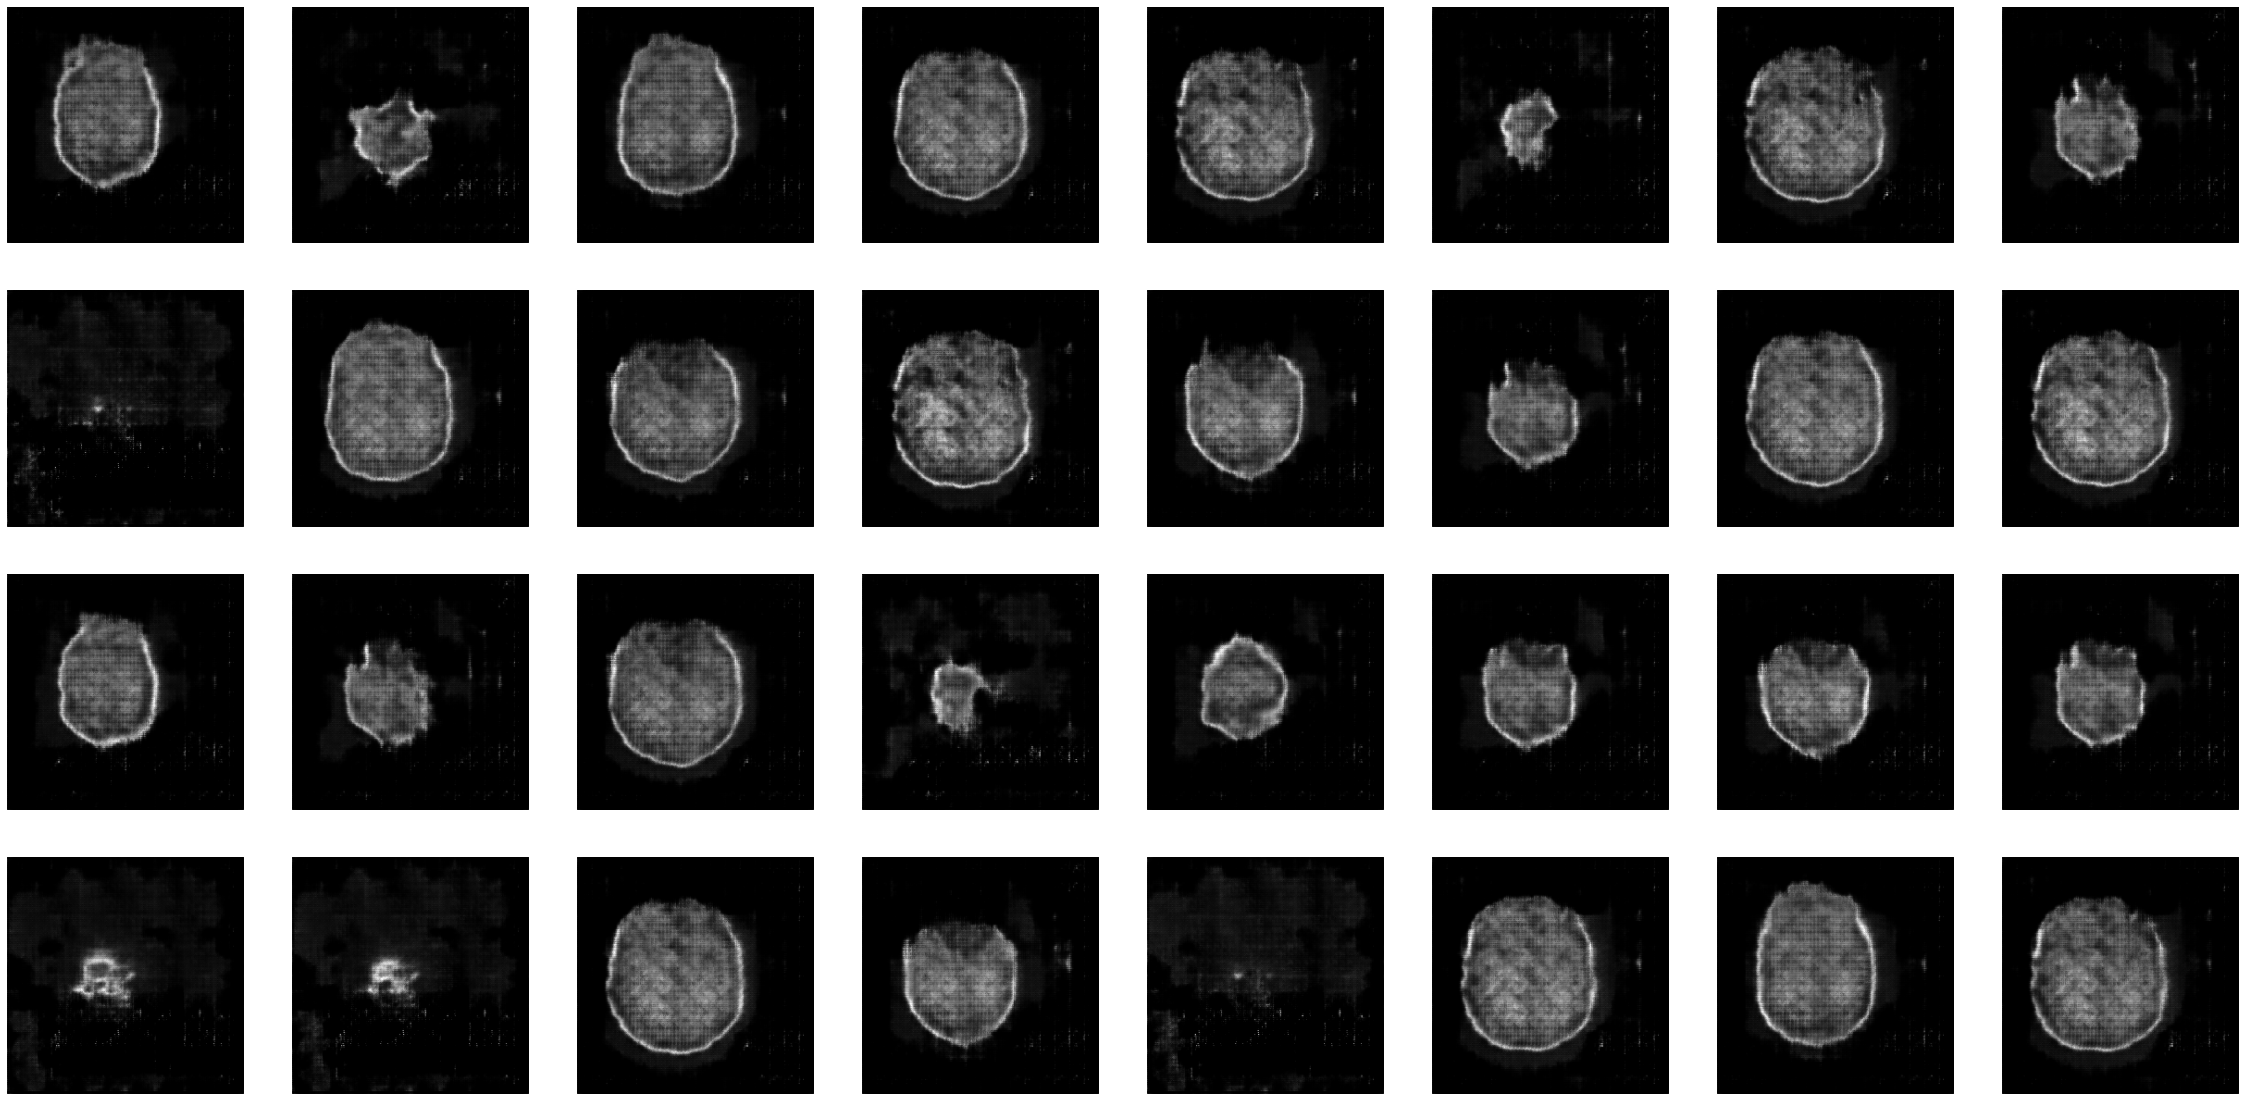

In [30]:
batch_size = 32
noise, cont_codes = generate_latent_points_lat_test(latent_dim, n_code_vec, batch_size)
noise = noise.to(DEVICE)
cont_codes = cont_codes.to(DEVICE)
fake_data, _ = generate_fake_samples(g_model, output, batch_size)
fake_data = fake_data.to(DEVICE)
fig = plt.figure(figsize=(40,20))
for i in range(batch_size):
    
    plt.subplot(4,8,i+1)
    plt.axis('off')
    plt.imshow(np.array(fake_data.detach().cpu())[i][0,:,:],cmap = 'gray')
plt.show()

In [ ]:
noise[2:4,1024-256:]

<function matplotlib.pyplot.show(close=None, block=None)>

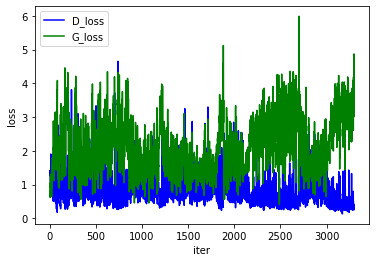

In [23]:
steps = range(len(D_losses))
y_1 = np.array(D_losses)
y_2 = np.array(G_losses)
plt.plot(steps,y_1,'b')
plt.plot(steps, y_2, 'g')
plt.legend(['D_loss','G_loss'], loc = 'best')
plt.xlabel('iter')
plt.ylabel('loss')
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

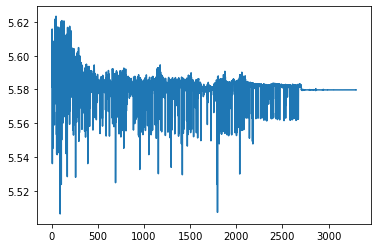

In [26]:
y = np.array(Q_losses)
plt.plot(steps,y)
plt.show

In [ ]:
# training of the projector network

In [24]:
P_loss = nn.MSELoss()

In [25]:
P_optim = optim.Adam([{'params':proj_model.parameters()}], lr=0.002)

In [26]:
Proj_losses = []
n_epochs_proj = 200
save_epoch_proj = 60
n_batches_proj = 30

In [ ]:
# for epoch in range(n_epochs_proj):
#     epoch_start_time = time.time()

#     for i in range(n_batches_proj):
        
#         P_optim.zero_grad()
        
#         noise_g, cont_codes_g = generate_latent_points(latent_dim, n_code_vec, batch_size)
#         noise_g = noise_g.to(DEVICE)
#         cont_codes_g = cont_codes_g.to(DEVICE)
#         fake_data_g, _ = generate_fake_samples(g_model, noise_g, batch_size)
#         fake_data_g = fake_data_g.to(DEVICE)
#         add_noise = torch.randn(batch_size, 65536).to(DEVICE)
#         inp = torch.reshape(fake_data_g.detach(),(-1,65536,))+add_noise
#         output = proj_model(inp)
#         proj_loss = P_loss(output, noise_g)
        
#         # Calculate gradients.
#         proj_loss.backward()
#         # Update parameters.
#         P_optim.step()

#         # Check progress of training.
#         if i != 0 and i%5 == 0:
#             print('[%d/%d][%d/%d]\tLoss_P: %.4f'% (epoch+1, n_epochs_proj, i, n_batches_proj, proj_loss.item()))

#         # Save the losses for plotting.
#         Proj_losses.append(proj_loss.item())


#     epoch_time = time.time() - epoch_start_time
#     print("Time taken for Epoch %d: %.2fs" %(epoch + 1, epoch_time))
    

In [27]:
for epoch in range(n_epochs_proj):
    epoch_start_time = time.time()

    for i in range(n_batches_proj):
        
        P_optim.zero_grad()
        
        real_data, real_labels = generate_real_samples(n_files, batch_size)
        real_data = real_data.to(DEVICE)
        add_noise = torch.randn(batch_size, 65536).to(DEVICE)
        inp = torch.reshape(real_data,(-1,65536,))+add_noise
        
        output = proj_model(inp)
        
        fake_data_g, _ = generate_fake_samples(g_model, output, batch_size)
        fake_data_g = torch.reshape(fake_data_g,(-1,65536,)).to(DEVICE)
        
        proj_loss = P_loss(fake_data_g, inp)
        
        # Calculate gradients.
        proj_loss.backward()
        # Update parameters.
        P_optim.step()

        # Check progress of training.
        if i != 0 and i%5 == 0:
            print('[%d/%d][%d/%d]\tLoss_P: %.4f'% (epoch+1, n_epochs_proj, i, n_batches_proj, proj_loss.item()))

        # Save the losses for plotting.
        Proj_losses.append(proj_loss.item())


    epoch_time = time.time() - epoch_start_time
    print("Time taken for Epoch %d: %.2fs" %(epoch + 1, epoch_time))
    

[1/200][5/30]	Loss_P: 1.0703
[1/200][10/30]	Loss_P: 1.0378
[1/200][15/30]	Loss_P: 1.0564
[1/200][20/30]	Loss_P: 1.0648
[1/200][25/30]	Loss_P: 1.0462
Time taken for Epoch 1: 9.78s
[2/200][5/30]	Loss_P: 1.0635
[2/200][10/30]	Loss_P: 1.0463
[2/200][15/30]	Loss_P: 1.0506
[2/200][20/30]	Loss_P: 1.0391
[2/200][25/30]	Loss_P: 1.0489
Time taken for Epoch 2: 9.81s
[3/200][5/30]	Loss_P: 1.0314
[3/200][10/30]	Loss_P: 1.0401
[3/200][15/30]	Loss_P: 1.0437
[3/200][20/30]	Loss_P: 1.0646
[3/200][25/30]	Loss_P: 1.0356
Time taken for Epoch 3: 9.79s
[4/200][5/30]	Loss_P: 1.0320
[4/200][10/30]	Loss_P: 1.0403
[4/200][15/30]	Loss_P: 1.0549
[4/200][20/30]	Loss_P: 1.0566
[4/200][25/30]	Loss_P: 1.0469
Time taken for Epoch 4: 9.60s
[5/200][5/30]	Loss_P: 1.0453
[5/200][10/30]	Loss_P: 1.0430
[5/200][15/30]	Loss_P: 1.0531
[5/200][20/30]	Loss_P: 1.0414
[5/200][25/30]	Loss_P: 1.0524
Time taken for Epoch 5: 9.58s
[6/200][5/30]	Loss_P: 1.0566
[6/200][10/30]	Loss_P: 1.0538
[6/200][15/30]	Loss_P: 1.0325
[6/200][20/30]	L

[45/200][25/30]	Loss_P: 1.0345
Time taken for Epoch 45: 9.57s
[46/200][5/30]	Loss_P: 1.0330
[46/200][10/30]	Loss_P: 1.0251
[46/200][15/30]	Loss_P: 1.0304
[46/200][20/30]	Loss_P: 1.0310
[46/200][25/30]	Loss_P: 1.0199
Time taken for Epoch 46: 9.52s
[47/200][5/30]	Loss_P: 1.0349
[47/200][10/30]	Loss_P: 1.0319
[47/200][15/30]	Loss_P: 1.0209
[47/200][20/30]	Loss_P: 1.0238
[47/200][25/30]	Loss_P: 1.0625
Time taken for Epoch 47: 9.60s
[48/200][5/30]	Loss_P: 1.0341
[48/200][10/30]	Loss_P: 1.0285
[48/200][15/30]	Loss_P: 1.0306
[48/200][20/30]	Loss_P: 1.0231
[48/200][25/30]	Loss_P: 1.0282
Time taken for Epoch 48: 9.56s
[49/200][5/30]	Loss_P: 1.0317
[49/200][10/30]	Loss_P: 1.0288
[49/200][15/30]	Loss_P: 1.0309
[49/200][20/30]	Loss_P: 1.0350
[49/200][25/30]	Loss_P: 1.0460
Time taken for Epoch 49: 9.50s
[50/200][5/30]	Loss_P: 1.0342
[50/200][10/30]	Loss_P: 1.0333
[50/200][15/30]	Loss_P: 1.0422
[50/200][20/30]	Loss_P: 1.0214
[50/200][25/30]	Loss_P: 1.0355
Time taken for Epoch 50: 9.65s
[51/200][5/30

[90/200][5/30]	Loss_P: 1.0294
[90/200][10/30]	Loss_P: 1.0233
[90/200][15/30]	Loss_P: 1.0353
[90/200][20/30]	Loss_P: 1.0305
[90/200][25/30]	Loss_P: 1.0196
Time taken for Epoch 90: 9.76s
[91/200][5/30]	Loss_P: 1.0255
[91/200][10/30]	Loss_P: 1.0300
[91/200][15/30]	Loss_P: 1.0251
[91/200][20/30]	Loss_P: 1.0194
[91/200][25/30]	Loss_P: 1.0139
Time taken for Epoch 91: 9.66s
[92/200][5/30]	Loss_P: 1.0235
[92/200][10/30]	Loss_P: 1.0256
[92/200][15/30]	Loss_P: 1.0278
[92/200][20/30]	Loss_P: 1.0366
[92/200][25/30]	Loss_P: 1.0215
Time taken for Epoch 92: 9.81s
[93/200][5/30]	Loss_P: 1.0223
[93/200][10/30]	Loss_P: 1.0252
[93/200][15/30]	Loss_P: 1.0169
[93/200][20/30]	Loss_P: 1.0311
[93/200][25/30]	Loss_P: 1.0165
Time taken for Epoch 93: 9.80s
[94/200][5/30]	Loss_P: 1.0149
[94/200][10/30]	Loss_P: 1.0204
[94/200][15/30]	Loss_P: 1.0454
[94/200][20/30]	Loss_P: 1.0353
[94/200][25/30]	Loss_P: 1.0293
Time taken for Epoch 94: 9.60s
[95/200][5/30]	Loss_P: 1.0291
[95/200][10/30]	Loss_P: 1.0163
[95/200][15/30

[133/200][15/30]	Loss_P: 1.0199
[133/200][20/30]	Loss_P: 1.0172
[133/200][25/30]	Loss_P: 1.0290
Time taken for Epoch 133: 9.86s
[134/200][5/30]	Loss_P: 1.0245
[134/200][10/30]	Loss_P: 1.0237
[134/200][15/30]	Loss_P: 1.0261
[134/200][20/30]	Loss_P: 1.0162
[134/200][25/30]	Loss_P: 1.0252
Time taken for Epoch 134: 9.83s
[135/200][5/30]	Loss_P: 1.0251
[135/200][10/30]	Loss_P: 1.0246
[135/200][15/30]	Loss_P: 1.0219
[135/200][20/30]	Loss_P: 1.0335
[135/200][25/30]	Loss_P: 1.0220
Time taken for Epoch 135: 9.79s
[136/200][5/30]	Loss_P: 1.0185
[136/200][10/30]	Loss_P: 1.0171
[136/200][15/30]	Loss_P: 1.0209
[136/200][20/30]	Loss_P: 1.0247
[136/200][25/30]	Loss_P: 1.0202
Time taken for Epoch 136: 9.86s
[137/200][5/30]	Loss_P: 1.0249
[137/200][10/30]	Loss_P: 1.0193
[137/200][15/30]	Loss_P: 1.0276
[137/200][20/30]	Loss_P: 1.0304
[137/200][25/30]	Loss_P: 1.0239
Time taken for Epoch 137: 9.84s
[138/200][5/30]	Loss_P: 1.0194
[138/200][10/30]	Loss_P: 1.0190
[138/200][15/30]	Loss_P: 1.0199
[138/200][20/

[176/200][15/30]	Loss_P: 1.0132
[176/200][20/30]	Loss_P: 1.0155
[176/200][25/30]	Loss_P: 1.0311
Time taken for Epoch 176: 9.67s
[177/200][5/30]	Loss_P: 1.0162
[177/200][10/30]	Loss_P: 1.0127
[177/200][15/30]	Loss_P: 1.0229
[177/200][20/30]	Loss_P: 1.0211
[177/200][25/30]	Loss_P: 1.0188
Time taken for Epoch 177: 9.70s
[178/200][5/30]	Loss_P: 1.0188
[178/200][10/30]	Loss_P: 1.0166
[178/200][15/30]	Loss_P: 1.0221
[178/200][20/30]	Loss_P: 1.0150
[178/200][25/30]	Loss_P: 1.0245
Time taken for Epoch 178: 9.52s
[179/200][5/30]	Loss_P: 1.0190
[179/200][10/30]	Loss_P: 1.0223
[179/200][15/30]	Loss_P: 1.0230
[179/200][20/30]	Loss_P: 1.0239
[179/200][25/30]	Loss_P: 1.0154
Time taken for Epoch 179: 9.55s
[180/200][5/30]	Loss_P: 1.0282
[180/200][10/30]	Loss_P: 1.0304
[180/200][15/30]	Loss_P: 1.0278
[180/200][20/30]	Loss_P: 1.0154
[180/200][25/30]	Loss_P: 1.0237
Time taken for Epoch 180: 9.64s
[181/200][5/30]	Loss_P: 1.0264
[181/200][10/30]	Loss_P: 1.0358
[181/200][15/30]	Loss_P: 1.0225
[181/200][20/

In [29]:
torch.save({'netP': proj_model.state_dict(),
           'P_optim': P_optim.state_dict()}, os.path.join(model_save_path, 'proj_trained_params_4_2_2.pth'))

<function matplotlib.pyplot.show(close=None, block=None)>

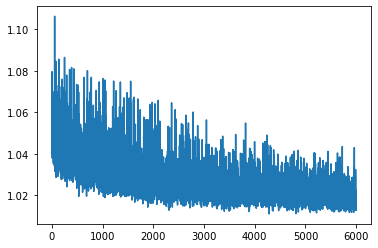

In [28]:
steps = range(len(Proj_losses))
y = np.array(Proj_losses)
plt.plot(steps,y)
plt.show

In [32]:
output[1,1024-265:]

tensor([-1.6864e+00, -6.4436e+00,  2.5807e+00,  1.8735e+00,  9.1084e-01,
        -1.0246e+01,  1.0967e+01, -1.0406e+01,  1.6449e+01,  1.7117e+01,
         3.4609e+01,  1.9252e+01,  1.6239e+01, -1.0696e+01,  5.1007e+01,
         1.2859e+01,  3.3007e+01, -5.4729e+00,  4.1333e+01,  1.4864e+01,
        -2.6600e+01,  6.5802e+01, -3.3656e+01, -5.0300e+01, -2.0463e+01,
        -3.6321e+01, -3.2290e+01,  4.3440e+01, -4.1434e+01, -3.5786e+01,
         1.1549e+01,  3.7158e+00,  5.5369e+00,  1.2160e+01, -2.8992e+01,
         1.2769e+01, -6.6161e+00, -4.0675e+01,  1.3246e+01,  6.5306e+00,
         3.7263e+00, -4.0092e+01, -4.4178e+01,  2.3860e+01,  3.1294e+00,
        -4.6063e+01, -1.4469e+01,  3.7115e+01, -3.3778e+01,  1.1944e+00,
        -2.7123e+01,  1.2206e+01,  8.9901e+00,  6.2591e+00, -9.8080e+00,
         1.8891e+01, -2.6900e+00, -1.8906e+00, -3.2082e+01, -1.7530e+01,
        -4.0701e+01, -4.4515e+01, -9.9665e+00, -4.5904e+01,  3.2644e+01,
        -4.2028e+01, -1.8844e+01,  1.9505e+01, -1.5